In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, sys, json, joblib
import pandas as pd
# !pip install openpyxl

In [2]:
def combinded(path):
    splitsort = []
    smaller = []
    for i in glob(os.path.join(path, '*log.csv')):
        splitname = os.path.basename(i).split('_')
        if len(splitname)==3:
            splitsort.append((int(splitname[0]),i))
        else:
            smaller.append(i)

    loss = []
    for i in list(np.array(sorted(splitsort))[:,1])+smaller:
        print(f"Processing file: {i}")
        loss.append(split(i)[:, 1])  # Get only the loss values (assumed to be in the second column)
    plt.plot(np.hstack(loss))
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    return plt
    # plt.show()

def split(path):
    """Helper function to read CSV file and extract required columns."""
    save = []
    with open(path, 'r') as f:
        for line in f:
            if ':' in line:
                split_line = line.strip().split(',')
                # Assuming the structure of each line is: [timestamp, loss_value, ...]
                save.append((float(split_line[1]), float(split_line[2])))
    return np.array(save)

In [3]:
# for i in sorted(glob('5/0.*/M-M-CZ_HWE-CNOT')):
#     combinded(i).legend(title=i)
#     plt.show()

In [4]:

trainsize=[ 0.1,0.3, 0.5, 0.7,0.8]
classical_models=['ridge', 'lasso', 'elastic', 'knn', 'rfr', 'grad', 'svr', 'krr', 'gpr'
]

classical_results=[]

for models in classical_models:
    for ts in trainsize:
        
        with open(f"./5/classical/{ts}_{models}_scores.json",'r') as f:
            classical_dict=json.load(f)
        classical_results.append((models,ts,'R2_train',classical_dict['R2_train']))
        classical_results.append((models,ts,'R2_test',classical_dict['R2_test']))

classical_df=pd.DataFrame(classical_results,columns=['model','ratio','set','value'])        

In [5]:

quantum_results = []
quantum_data = []
results = {}
for i in sorted(glob('5/*/M-M-CZ_HWE-CNOT/M-M-CZ_HWE-CNOT_results.json')):
    print(i)
    with open(i,'r') as f:
        data = json.load(f)
    ratio = os.path.basename(os.path.dirname(os.path.dirname(i)))
    quantum_data.append((ratio,data['R2_train'],data['R2_test']))
    quantum_results.append(('M-M-CZ_HWE-CNOT',ratio,'R2_train',data['R2_train']))
    quantum_results.append(("M-M-CZ_HWE-CNOT",ratio,'R2_test',data['R2_test']))

quantum_data = np.array(quantum_data).astype(float)
quantum_df=pd.DataFrame(quantum_results,columns=['model','ratio','set','value'])
combined_df = pd.concat([classical_df,quantum_df])

5/0.1/M-M-CZ_HWE-CNOT/M-M-CZ_HWE-CNOT_results.json
5/0.3/M-M-CZ_HWE-CNOT/M-M-CZ_HWE-CNOT_results.json
5/0.5/M-M-CZ_HWE-CNOT/M-M-CZ_HWE-CNOT_results.json
5/0.7/M-M-CZ_HWE-CNOT/M-M-CZ_HWE-CNOT_results.json
5/0.8/M-M-CZ_HWE-CNOT/M-M-CZ_HWE-CNOT_results.json


In [6]:
combined_df.pivot(columns=['set'],values='value',index=['ratio','model']).to_excel(os.path.join(os.path.expanduser('~'),'qregress/spreadsheets/BSE5_lc.xlsx'))

In [7]:
print(combined_df.pivot(columns=['set'],values='value',index=['ratio','model']).sort_index(axis=1,ascending=False).round(4).to_latex(float_format="{:.4f}".format))

\begin{tabular}{llrr}
\toprule
 & set & R2_train & R2_test \\
ratio & model &  &  \\
\midrule
\multirow[t]{9}{*}{0.100000} & elastic & 0.1787 & 0.1229 \\
 & gpr & 0.3254 & 0.2147 \\
 & grad & 0.9010 & 0.3352 \\
 & knn & 0.9998 & 0.3963 \\
 & krr & 0.4242 & 0.2811 \\
 & lasso & 0.1786 & 0.1229 \\
 & rfr & 0.8896 & 0.4220 \\
 & ridge & 0.1789 & 0.1226 \\
 & svr & 0.4020 & 0.2719 \\
\cline{1-4}
\multirow[t]{9}{*}{0.300000} & elastic & 0.2099 & 0.2012 \\
 & gpr & 0.4211 & 0.3857 \\
 & grad & 0.8896 & 0.5215 \\
 & knn & 0.9998 & 0.5837 \\
 & krr & 0.4967 & 0.4385 \\
 & lasso & 0.2094 & 0.2002 \\
 & rfr & 0.9455 & 0.5589 \\
 & ridge & 0.2100 & 0.2015 \\
 & svr & 0.4881 & 0.4287 \\
\cline{1-4}
\multirow[t]{9}{*}{0.500000} & elastic & 0.1960 & 0.2050 \\
 & gpr & 0.4383 & 0.4377 \\
 & grad & 0.9350 & 0.5721 \\
 & knn & 0.9998 & 0.6222 \\
 & krr & 0.4724 & 0.4612 \\
 & lasso & 0.1954 & 0.2039 \\
 & rfr & 0.9453 & 0.5970 \\
 & ridge & 0.1961 & 0.2055 \\
 & svr & 0.4754 & 0.4628 \\
\cline{1-4}
\mu

In [8]:
combined_df = combined_df.astype({'model':str,'ratio':float,"set":str,'value':float})
combined_df['set'] = [i.split('_')[1].capitalize() for i in combined_df['set']]

train = combined_df[(combined_df['model']=='M-M-CZ_HWE-CNOT')&(combined_df['set']=='Train')]
test = combined_df[(combined_df['model']=='M-M-CZ_HWE-CNOT')&(combined_df['set']=='Test')]

drop_pqc = combined_df[combined_df['model']!='M-M-CZ_HWE-CNOT']

In [27]:
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# drop_pqc_adj = drop_pqc.copy()
# # Assuming drop_pqc_adj and quantum_data are already defined
# r_df = pd.DataFrame(quantum_data, columns=['index', 'Train', 'Test']).melt(id_vars=['index'], value_vars=['Train', 'Test'])
# r_df['variable'] = [i + " (M-M-CZ_HWE-CNOT)" for i in r_df['variable']]

# drop_pqc_adj['set'] = [i + " (classical)" for i in drop_pqc_adj['set']]
# xticks = np.linspace(0, 0.9, 10)

# # Main plot
# # ax1 = sns.lineplot(data=drop_pqc_adj, x='ratio', y='value', hue='set', style='set', palette=(sns.color_palette('Paired', 6)[3],sns.color_palette('Paired', 6)[5]),errorbar=lambda x: (x.min(), x.max()),err_style='bars')
# ax = sns.lineplot(data=r_df, x='index', y='value', hue='variable', style='variable', palette=sns.color_palette('Paired', 2), markers=['>', '<'])
# plt.ylim(0, 1.05)
# ax.set_xticks(xticks)
# ax.set_xticklabels([f"{int(x * 100)}%" for x in xticks])
# plt.ylabel('R$^{2}$')
# plt.xlabel('Training Set (%)')
# plt.title('M-M-CZ_HWE-CNOT')
# plt.legend(loc=2)

# # Inlay plot
# inset_ax = inset_axes(ax, width="40%", height="40%",loc=4,bbox_to_anchor=(100, 250,500, 400))  # Adjust width, height, and location as needed
# sns.lineplot(data=drop_pqc_adj, x='ratio', y='value', hue='set', style='set', palette=(sns.color_palette('Paired', 6)[3],sns.color_palette('Paired', 6)[5]),errorbar=lambda x: (x.min(), x.max()), ax=inset_ax, legend=False,err_style='bars')
# # inset_ax.set_xlim(0.9, 1)  # Adjust the range as needed
# inset_ax.legend()
# inset_ax.set_ylim(0, 1.1)  # Adjust the y-axis limits as needed
# inset_ax.set_xticks(xticks[0::2])
# inset_ax.set_xticklabels([f"{int(x * 100)}%" for x in xticks[0::2]])
# inset_ax.set_ylabel('R$^{2}$')
# inset_ax.set_xlabel('Training Set (%)')
# inset_ax.set_title('Classical Models')
# plt.tight_layout()
# plt.savefig(f"{os.path.expanduser('~')}/qregress/images/BSE/fivequbit/BSE_learningcurve.png", bbox_inches='tight', pad_inches=0.1)
# plt.show()

In [99]:
help(combined_df.pivot)

Help on method pivot in module pandas.core.frame:

pivot(*, columns, index=<no_default>, values=<no_default>) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Return reshaped DataFrame organized by given index / column values.

    Reshape data (produce a "pivot" table) based on column values. Uses
    unique values from specified `index` / `columns` to form axes of the
    resulting DataFrame. This function does not support data
    aggregation, multiple values will result in a MultiIndex in the
    columns. See the :ref:`User Guide <reshaping>` for more on reshaping.

    Parameters
    ----------
    columns : str or object or a list of str
        Column to use to make new frame's columns.
    index : str or object or a list of str, optional
        Column to use to make new frame's index. If not given, uses existing index.
    values : str, object or a list of the previous, optional
        Column(s) to use for populating new frame's values. If not
        specifi

In [111]:
pivot_df = combined_df.pivot(index=['ratio','set'],values=['value'],columns=['model'])

# .T.idxmax()

In [157]:
combined_df.query("model == 'knn' & set == 'Test' ").describe().round(4).loc['mean','value']

0.5822

In [160]:
combined_df.query("model == 'M-M-CZ_HWE-CNOT' & set == 'Train' ").describe().round(4).loc['max','value']

0.2015

In [166]:
combined_df.query("model == 'M-M-CZ_HWE-CNOT' & set == 'Test' ").round(4)

,model,ratio,set,value
1,M-M-CZ_HWE-CNOT,0.1,Test,0.1303
3,M-M-CZ_HWE-CNOT,0.3,Test,-0.0088
5,M-M-CZ_HWE-CNOT,0.5,Test,0.1792
7,M-M-CZ_HWE-CNOT,0.7,Test,0.2064
9,M-M-CZ_HWE-CNOT,0.8,Test,0.1727


In [148]:
pivot_df.T.query("model == 'knn'")

ratio             0.1                 0.3                 0.5           \
set              Test     Train      Test     Train      Test    Train   
      model                                                              
value knn    0.396254  0.999808  0.583678  0.999844  0.622153  0.99982   

ratio            0.7                 0.8            
set             Test     Train      Test     Train  
      model                                         
value knn    0.63664  0.999842  0.672524  0.999851

In [122]:
pivot_df.T[0.8].sort_values(by=['Train','Test'])

set                        Test     Train
      model                              
value M-M-CZ_HWE-CNOT  0.172747  0.155860
      lasso            0.181249  0.165078
      elastic          0.182761  0.165645
      ridge            0.183368  0.165716
      gpr              0.460736  0.444453
      svr              0.467099  0.457777
      krr              0.472730  0.459626
      rfr              0.640047  0.946200
      grad             0.603009  0.953052
      knn              0.672524  0.999851

In [98]:
combined_df[combined_df['ratio']==0.1].sort_values(by=['value','set'])

,model,ratio,set,value
1,ridge,0.1,Test,0.122627
11,lasso,0.1,Test,0.122909
21,elastic,0.1,Test,0.122939
1,M-M-CZ_HWE-CNOT,0.1,Test,0.130335
10,lasso,0.1,Train,0.178600
20,elastic,0.1,Train,0.178735
0,ridge,0.1,Train,0.178932
0,M-M-CZ_HWE-CNOT,0.1,Train,0.201537
81,gpr,0.1,Test,0.214707
61,svr,0.1,Test,0.271886


/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_6248/2547232104.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


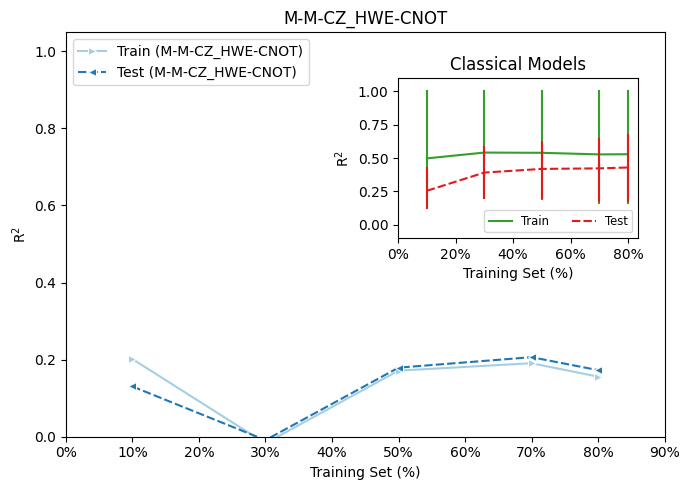

In [88]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
drop_pqc_adj = drop_pqc.copy()
# Assuming drop_pqc_adj and quantum_data are already defined
r_df = pd.DataFrame(quantum_data, columns=['index', 'Train', 'Test']).melt(id_vars=['index'], value_vars=['Train', 'Test'])
r_df['variable'] = [i + " (M-M-CZ_HWE-CNOT)" for i in r_df['variable']]

drop_pqc_adj['set'] = [i + " (classical)" for i in drop_pqc_adj['set']]
xticks = np.linspace(0, 0.9, 10)
fig = plt.figure(figsize=(7,5))
# Main plot
# ax1 = sns.lineplot(data=drop_pqc_adj, x='ratio', y='value', hue='set', style='set', palette=(sns.color_palette('Paired', 6)[3],sns.color_palette('Paired', 6)[5]),errorbar=lambda x: (x.min(), x.max()),err_style='bars')
ax = sns.lineplot(data=r_df, x='index', y='value', hue='variable', style='variable', palette=sns.color_palette('Paired', 2), markers=['>', '<'])
plt.ylim(0, 1.05)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{int(x * 100)}%" for x in xticks])
plt.ylabel('R$^{2}$')
plt.xlabel('Training Set (%)')
plt.title('M-M-CZ_HWE-CNOT')
plt.legend(loc=2)


# Inlay plot
inset_ax = inset_axes(ax, width="40%", height="40%", loc=4, bbox_to_anchor=(50, 250, 600, 400))  # Adjust location as needed

# Plot with legend temporarily enabled
sns_plot = sns.lineplot(
    data=drop_pqc_adj,
    x='ratio',
    y='value',
    hue='set',
    style='set',
    palette=(sns.color_palette('Paired', 6)[3], sns.color_palette('Paired', 6)[5]),
    errorbar=lambda x: (x.min(), x.max()),
    ax=inset_ax,
    err_style='bars',
    legend=True  # Enable legend just to capture handles
)

# Get handles and labels
handles, labels = inset_ax.get_legend_handles_labels()

# Manually reset legend with new labels
inset_ax.legend(loc=4,handles=handles, labels=["Train", "Test"], fontsize='small',ncols=2)

# Final axis formatting
inset_ax.set_ylim(-0.1, 1.1)
inset_ax.set_xticks(xticks[0::2])
inset_ax.set_xticklabels([f"{int(x * 100)}%" for x in xticks[0::2]])
inset_ax.set_ylabel('R$^{2}$')
inset_ax.set_xlabel('Training Set (%)')
inset_ax.set_title('Classical Models')
plt.tight_layout()
plt.savefig(f"{os.path.expanduser('~')}/qregress/images/BSE/fivequbit/BSE_learningcurve.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [18]:
drop_pqc_adj

,model,ratio,set,value
0,ridge,0.1,Train (classical),0.178932
1,ridge,0.1,Test (classical),0.122627
2,ridge,0.3,Train (classical),0.209983
3,ridge,0.3,Test (classical),0.201498
4,ridge,0.5,Train (classical),0.196100
...,...,...,...,...
85,gpr,0.5,Test (classical),0.437748
86,gpr,0.7,Train (classical),0.434667
87,gpr,0.7,Test (classical),0.451629
88,gpr,0.8,Train (classical),0.444453


In [10]:
ax = sns.lineplot(data=r_df.T[['R2_train','R2_test']].reset_index().rename(columns={'R2_train':"Train",'R2_test':"Test"}).melt(id_vars=['index'], value_vars=['Train','Test']),x='index',y='value',hue='variable',style='variable',palette=sns.color_palette('Paired',2),markers=['>','<'])

plt.ylim(-.2,1)
# plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))  # Adjust xmax if needed
ax.set_xticklabels([f"{int(i*100)}%" for i in np.array(r_df.columns,dtype=float)])
plt.ylabel('R$^{2}$')
plt.xlabel('Training Set (%)')
plt.title('M-M-CZ_HWE-CNOT')
plt.legend(loc=2)
plt.savefig(f"{os.path.expanduser('~')}/qregress/images/BSE/fivequbit/BSE_learningcurve.png", bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.show()

KeyError: "None of [Index(['R2_train', 'R2_test'], dtype='object')] are in the [columns]"

In [ ]:

results = {}
for i in sorted(glob('16/*/A2_Hadamard/A2_Hadamard_results.json')):
    print(i)
    ratio = os.path.basename(os.path.dirname(os.path.dirname(i)))
    with open(i,'r') as f:
        results[ratio]=json.load(f)
        
    results[ratio]['Train Size'] = joblib.load(glob(os.path.join(os.path.dirname(os.path.dirname(i)),'*Morgan_train.bin'))[0])['X'].shape[0]

r_df = pd.DataFrame(results).drop(index=['MSE_train','MSE_test'])


ax = sns.lineplot(data=r_df.T[['R2_train','R2_test']].reset_index().rename(columns={'R2_train':"Train",'R2_test':"Test"}).melt(id_vars=['index'], value_vars=['Train','Test']),x='index',y='value',hue='variable',style='variable',palette=sns.color_palette('Paired',2),markers=['>','<'])

plt.ylim(-0.2,1)
# plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))  # Adjust xmax if needed
ax.set_xticklabels([f"{int(i*100)}%" for i in np.array(r_df.columns,dtype=float)])
plt.ylabel('R$^{2}$')
plt.xlabel('Training Set (%)')
plt.title('A2_Hadamard')
plt.legend(loc=2)
plt.savefig(f"{os.path.expanduser('~')}/qregress/images/BSE/sixteenqubit/BSE_learningcurve.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
ax.get_xticklabels()